In [2]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from typing import Optional, Union
import seaborn as sns
import scipy
from scipy.spatial import distance
from scipy.spatial.distance import cdist

/slurm/home/yrd/liaolab/caohaoxue/anaconda3/envs/my_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/E12_to_CS10_sum1e4.h5ad')

# Model Definition

In [3]:
class TimeSeriesVAE(nn.Module):
    
    def __init__(self, input_dim, latent_dim=15):
        super(TimeSeriesVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        enc = self.encoder(x)
        mu = self.fc_mu(enc)
        logvar = self.fc_logvar(enc)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar, beta=0.5):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [5]:
def train_vae(model, dataloader, epochs=100, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in dataloader:
            data = data[0].to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_loss = train_loss / len(dataloader.dataset)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    return model

In [6]:
def save_model(model, adata, model_path='sc_vae_model.pth'):
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.encoder[0].in_features,
        'latent_dim': model.fc_mu.out_features
        }, model_path)
    
def load_model(model_path='sc_vae_model.pth', device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    checkpoint = torch.load(model_path, map_location=device)
    
    model = TimeSeriesVAE(
        input_dim=checkpoint['input_dim'],
        latent_dim=checkpoint['latent_dim']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"load from {model_path}")
    print(f"input dim: {checkpoint['input_dim']}, latent dim: {checkpoint['latent_dim']}")
    
    return model

# Model Setup and Simulation

In [7]:
dataset = TensorDataset(torch.tensor(adata.X, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [8]:
input_dim = torch.tensor(adata.X, dtype=torch.float32).shape[1]
model = TimeSeriesVAE(input_dim, latent_dim=15)

## Model Train

In [9]:
trained_model = train_vae(model, dataloader, epochs=80, lr=1e-4)

Epoch 10/80, Loss: 700679.7460
Epoch 20/80, Loss: 700534.1887
Epoch 30/80, Loss: 700451.2405
Epoch 40/80, Loss: 700390.4646
Epoch 50/80, Loss: 700346.3412
Epoch 60/80, Loss: 700316.9253
Epoch 70/80, Loss: 700296.8462
Epoch 80/80, Loss: 700281.0272


In [10]:
save_model(trained_model, adata, 'E12_to_CS10train_model_lr1e4.pth')

## Simulation

In [9]:
trained_model = load_model('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/E12_to_CS10train_model_lr1e4.pth')

load from /slurm/home/yrd/liaolab/caohaoxue/embryo_work/E12_to_CS10train_model_lr1e4.pth
input dim: 71540, latent dim: 15


In [32]:
device = next(trained_model.parameters()).device

t1_tensor = torch.tensor(adata[adata.obs.time=='CS7'].X.toarray(), dtype=torch.float32).to(device)
t2_tensor = torch.tensor(adata[adata.obs.time=='CS9'].X.toarray(), dtype=torch.float32).to(device)

torch.manual_seed(42)
with torch.no_grad():
        z_t1, _, _ = trained_model.encode(t1_tensor)
        z_t2, _, _ = trained_model.encode(t2_tensor)

In [33]:
latent_7 = z_t1.cpu().numpy()
latent_9 = z_t2.cpu().numpy()
latent_7 = pd.DataFrame(data = latent_7, index = adata[adata.obs['time'] == 'CS7'].obs.index)
latent_9 = pd.DataFrame(data = latent_9, index = adata[adata.obs['time'] == 'CS9'].obs.index)

In [34]:
distances = distance.cdist(latent_7, latent_9, metric='euclidean')
distances = pd.DataFrame(index = adata[adata.obs['time'] == 'CS7'].obs.index, columns = adata[adata.obs['time'] == 'CS9'].obs.index, data = distances)
min_dis = distances.idxmin().to_dict()
latent_mid = pd.DataFrame(latent_9.columns).T
for key,value in min_dis.items():
    cell_end = latent_9.loc[key]
    cell_start = latent_7.loc[value]
    cell_mid = pd.DataFrame((cell_end + cell_start)/2)
    latent_mid = np.vstack((latent_mid, cell_mid.T))
latent_mid = latent_mid[1:, :]

In [36]:
z_mid = torch.tensor(latent_mid, dtype=torch.float32).to(device)

with torch.no_grad():
    mid_cell = trained_model.decode(z_mid).cpu().numpy()

In [37]:
CS8_name = new_list = [s[:-1] + "8-f" if s else s for s in adata[adata.obs['time'] == 'CS9'].obs.index]

adata_interpolated = sc.AnnData(X=pd.DataFrame(data = mid_cell,
                                              index = adata[adata.obs['time'] == 'CS9'].obs.index,
                                              columns = adata[adata.obs['time'] == 'CS9'].var.index),
                               obs = adata[adata.obs['time'] == 'CS9'].obs)

adata_interpolated.var['features'] = adata_interpolated.var.index

In [38]:
adata_interpolated.obs.time = 'CS8-f'
adata_interpolated.obs.batch = 'CS8-f'
adata_interpolated.obs.index = CS8_name

In [39]:
adata_interpolated.X.sum(axis = 1)

array([5348.47  , 4003.317 , 5545.911 , ..., 4921.6104, 5450.932 ,
       4989.677 ], shape=(6694,), dtype=float32)

In [40]:
sc.pp.normalize_total(adata_interpolated, target_sum=1e4)

In [41]:
adata_interpolated.write_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/simulation_sc/CS8f_VAE_normalizedX_euc_lr1e3.h5ad')

# Data Check: Location in E12 to CS10

In [3]:
adata_interpolated = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/simulation_sc/CS8f_VAE_normalizedX_lr1e3_clustered.h5ad')

In [4]:
adata_interpolated.obs

nCount_RNA  nFeature_RNA   time merge_type  \
AAACCCAAGCCAAGGT-1-CS8-f      1387.0           929  CS8-f   Endoderm   
AAACCCAAGGTAGTCG-1-CS8-f       526.0           414  CS8-f   Mesoderm   
AAACCCACAACGCATT-1-CS8-f      7364.0          3806  CS8-f    YolkSac   
AAACCCACAATCTCGA-1-CS8-f      3127.0          1946  CS8-f   Ectoderm   
AAACCCACACATCATG-1-CS8-f      2073.0          1339  CS8-f   Mesoderm   
...                              ...           ...    ...        ...   
TTTGTTGGTACTCGAT-1-CS8-f      6125.0          2729  CS8-f   Mesoderm   
TTTGTTGGTCAGTCTA-1-CS8-f      1500.0          1069  CS8-f   Mesoderm   
TTTGTTGGTTCGGCTG-1-CS8-f      1303.0           809  CS8-f    YolkSac   
TTTGTTGGTTGTGGCC-1-CS8-f     11177.0          4530  CS8-f   Mesoderm   
TTTGTTGTCCACCCTA-1-CS8-f      3684.0          1994  CS8-f   Endoderm   

                                  cell_type  batch leiden  
AAACCCAAGCCAAGGT-1-CS8-f           Endoderm  CS8-f      6  
AAACCCAAGGTAGTCG-1-CS8-f           Notocord  CS8-f      4  
AAACCCACAACGCATT-1-CS8-f    YS.EXE.Mesoderm  CS8-f      0  
AAACCCACAATCTCGA-1-CS8-f           Ectoderm  CS8-f      3  
AAACCCACACATCATG-1-CS8-f                HEP  CS8-f      2  
...                                     ...    ...    ...  
TTTGTTGGTACTCGAT-1-CS8-f  Advanced Mesoderm  CS8-f     12  
TTTGTTGGTCAGTCTA-1-CS8-f           Notocord  CS8-f      4  
TTTGTTGGTTCGGCTG-1-CS8-f    YS.EXE.Mesoderm  CS8-f      0  
TTTGTTGGTTGTGGCC-1-CS8-f           Notocord  CS8-f      4  
TTTGTTGTCCACCCTA-1-CS8-f           Endoderm  CS8-f      6  

[6694 rows x 7 columns]

In [60]:
adata_combined = adata.concatenate(adata_interpolated, batch_key='source')

/tmp/ipykernel_49052/1281166927.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata.concatenate(adata_interpolated, batch_key='source')


In [61]:
sc.pp.log1p(adata_combined)

/slurm/home/yrd/liaolab/caohaoxue/anaconda3/envs/my_env/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


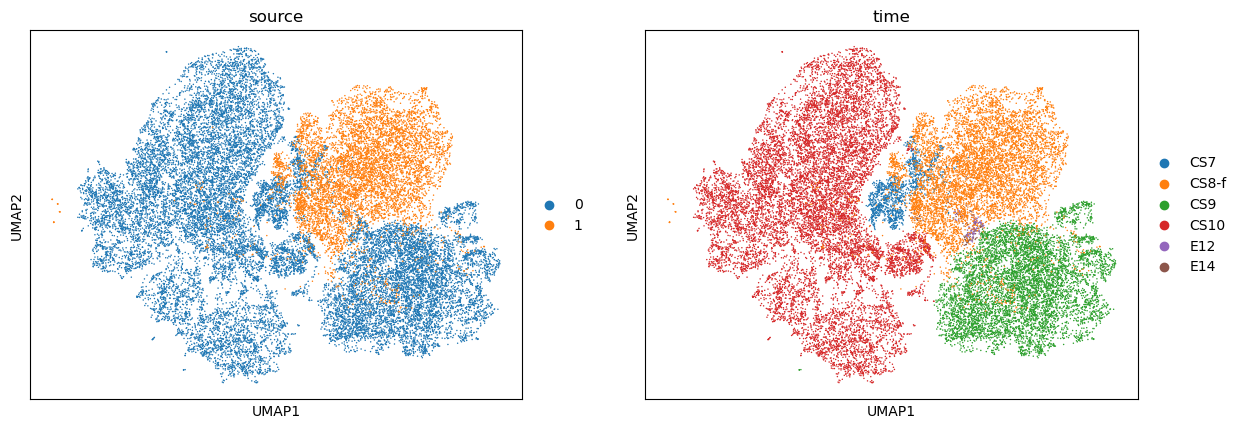

In [62]:
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.external.pp.bbknn(adata_combined, batch_key='source')
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color=['source','time'])

In [ ]:
adata_combined = adata_combined[adata_combined.obs.time.isin (['CS7','CS8-f','CS9'])]

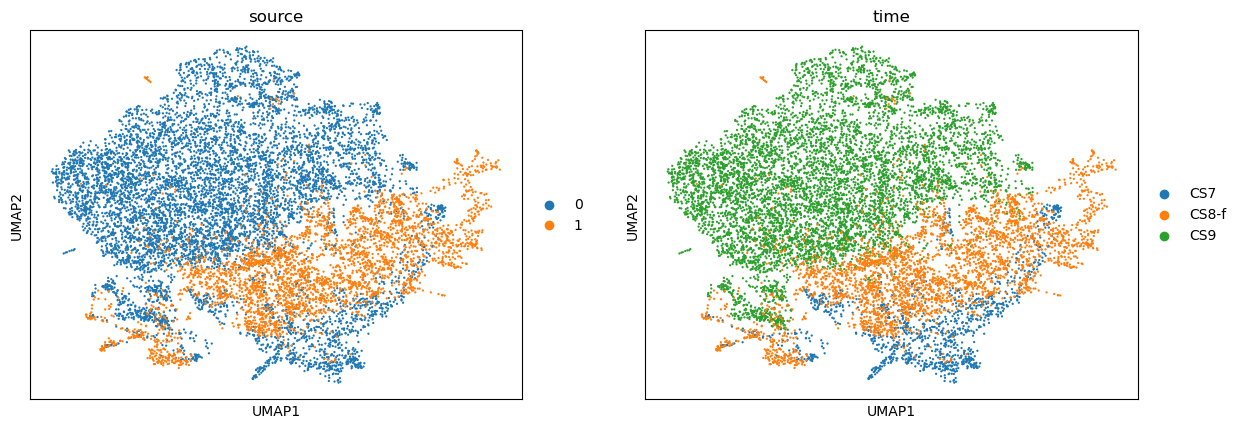

In [ ]:
sc.external.pp.bbknn(adata_combined, batch_key='source')
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color=['source','time'])

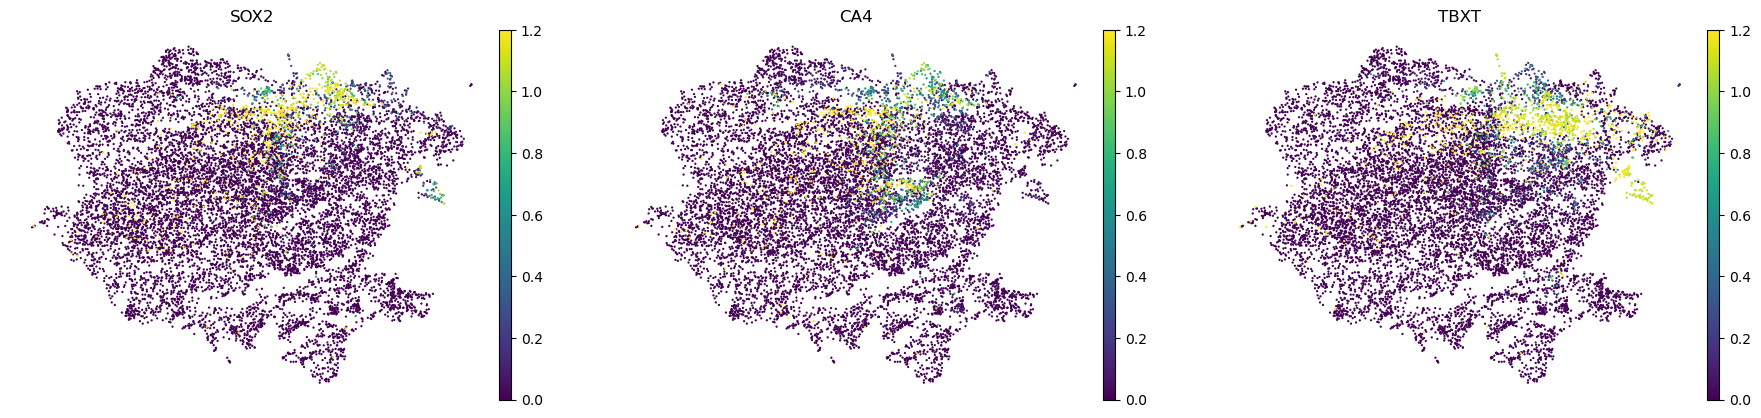

In [20]:
sc.pl.umap(adata_combined, color = ['SOX2','CA4','TBXT'], frameon = False, vmax = 1.2, use_raw=False)

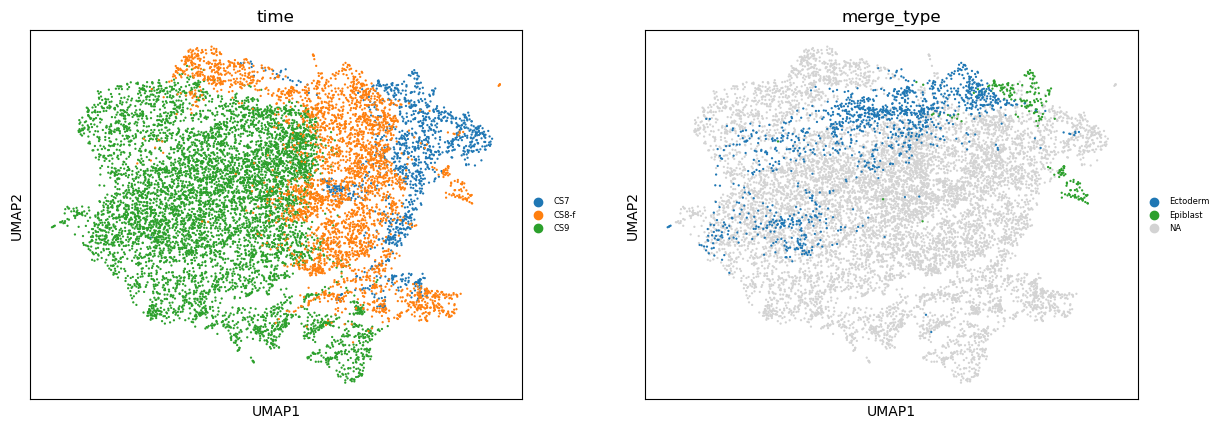

In [27]:
sc.pl.umap(adata_combined, color=['time','merge_type'], groups=['CS7','CS8-f','CS9','Ectoderm','Epiblast',], legend_fontsize=6)

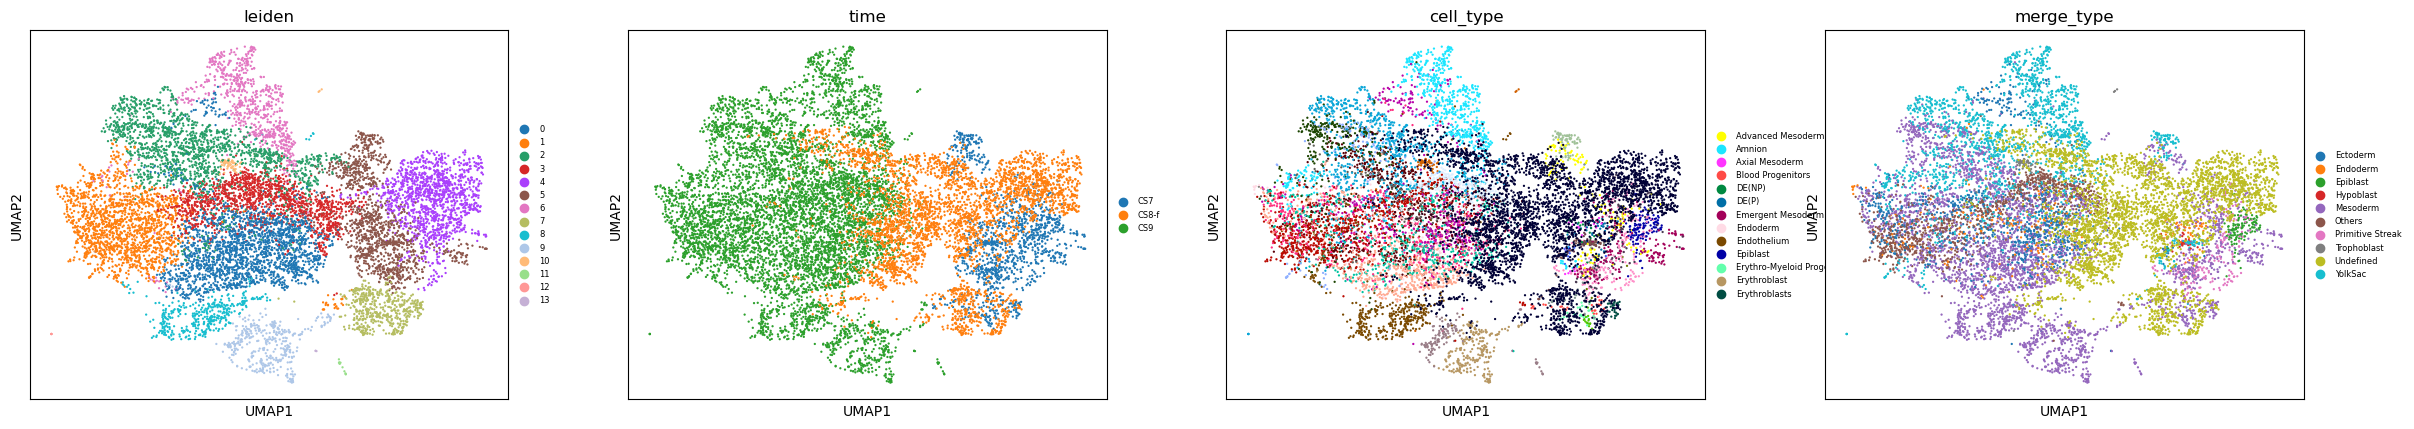

In [ ]:
sc.tl.leiden(adata_combined, resolution=0.3)
sc.pl.umap(adata_combined, color=['leiden','time','cell_type','merge_type'], legend_fontsize=6)

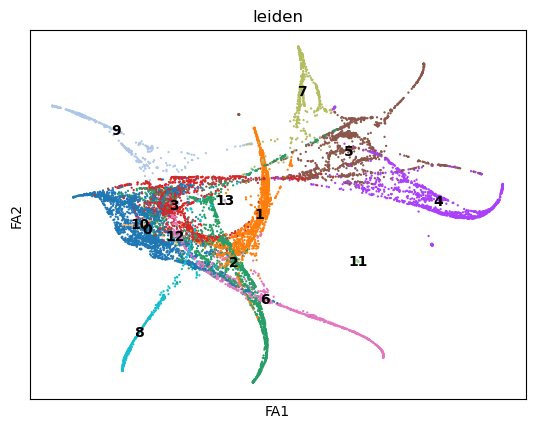

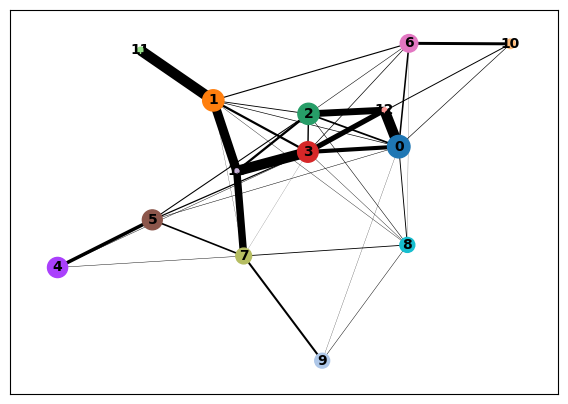

In [127]:
sc.tl.diffmap(adata_combined)
sc.pp.neighbors(adata_combined, use_rep="X_diffmap")
sc.tl.draw_graph(adata_combined)
sc.pl.draw_graph(adata_combined, color="leiden", legend_loc="on data")
sc.tl.paga(adata_combined, groups="leiden")
sc.pl.paga(adata_combined, color=["leiden"])

<Axes: >

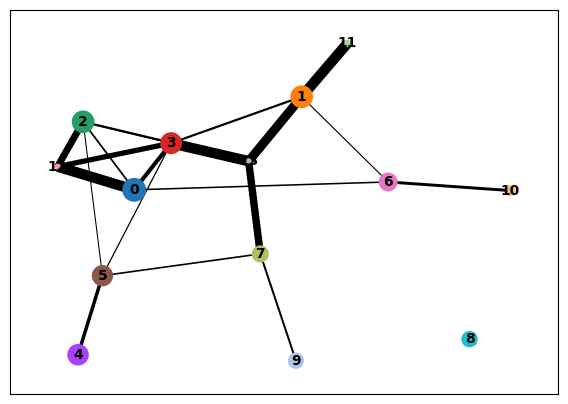

In [129]:
sc.pl.paga(adata_combined, threshold=0.1, show=False)

In [132]:
start_cluster = adata_combined[adata_combined.obs['merge_type'] == 'Epiblast'].obs['leiden'].mode()[0]
end_cluster = adata_combined[adata_combined.obs['merge_type'] == 'Ectoderm'].obs['leiden'].mode()[0]
print(start_cluster , end_cluster)

4 0


In [133]:
adata_combined

AnnData object with n_obs × n_vars = 11236 × 71540
    obs: 'nCount_RNA', 'nFeature_RNA', 'time', 'merge_type', 'cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'source', 'leiden'
    var: 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'features-1'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'source_colors', 'time_colors', 'leiden', 'leiden_colors', 'cell_type_colors', 'merge_type_colors', 'diffmap_evals', 'draw_graph', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [135]:
from scipy.sparse.csgraph import shortest_path

In [136]:
paga_connectivities = adata_combined.uns['paga']['connectivities']
clusters = pd.Categorical(adata_combined.obs['leiden']).categories
start_idx = np.where(clusters == '4')[0][0]
end_idx = np.where(clusters == '0')[0][0]
dist_matrix = 1 / (paga_connectivities.toarray() + 1e-6)  # 避免除零
_, path = shortest_path(dist_matrix, directed=False, indices=start_idx, return_predecessors=True)
trajectory_clusters = []
current = end_idx
while current != start_idx:
    trajectory_clusters.append(clusters[current])
    current = path[current]
trajectory_clusters.append(clusters[start_idx])
trajectory_clusters = trajectory_clusters[::-1]
trajectory_clusters

['4', '5', '3', '0']

In [141]:
adata_combined_N = adata_combined[adata_combined.obs.leiden.isin(['4', '5', '3', '0'])]

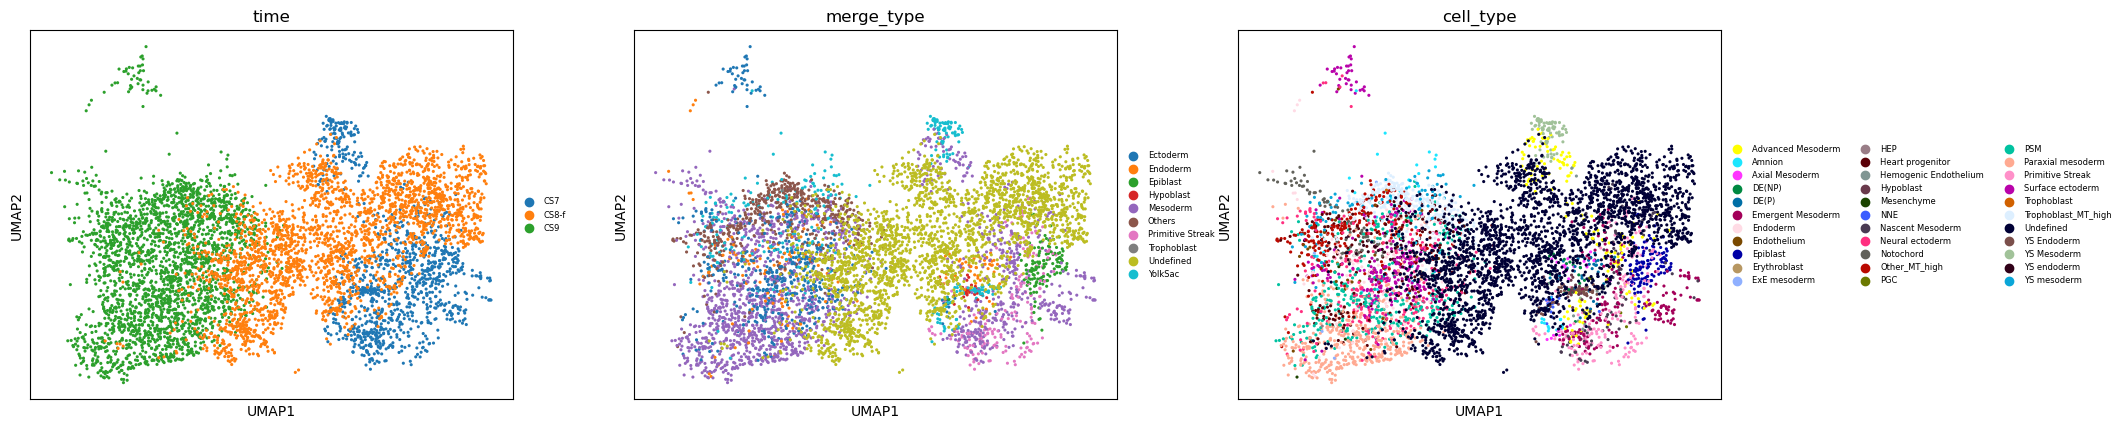

In [143]:
sc.pl.umap(adata_combined_N, color=['time','merge_type','cell_type'], legend_fontsize=6)

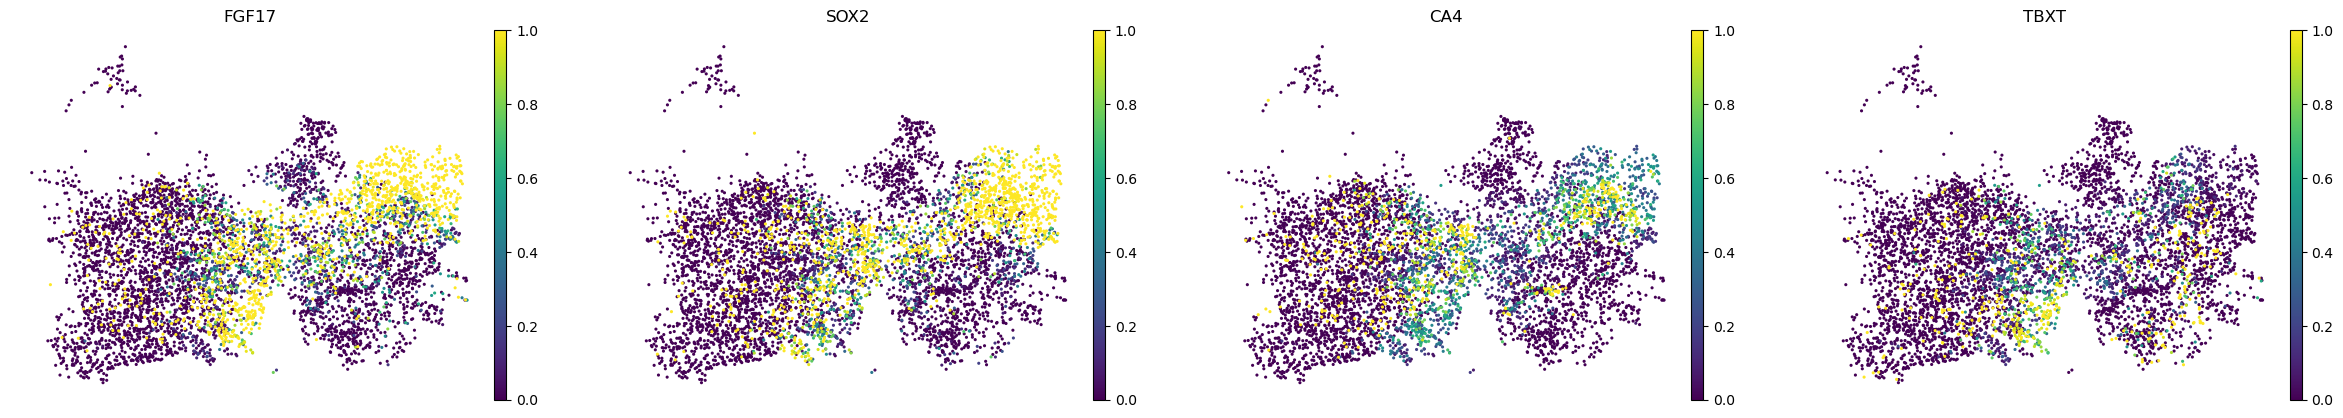

In [160]:
sc.pl.umap(adata_combined_N, color = ['FGF17','SOX2','CA4','TBXT'], frameon = False, vmax = 1, use_raw=False)